# Obtaining a riders's power data a KOM
## Michal Kwiatkowski's KOM data on the Poggio (Milan San Remo win)
This is the activity we are going to analyse https://www.strava.com/activities/905223228 <br>
We start with Michal's strava_id=1905161. You cannot download this activity without authorisation. However, you can obtain a list of KOMs, which are SegmentEfforts. And you can download a stream of a SegementEffort. In theory, if you turn the whole activity into a segment, you can obtain a fell stream for that activity.<br> **At the end of the day, you just need to obtain the effort_id for the segment. Then you can pull in the leaderboard data using get_segment_effort(effort_id) and streams of the underlying data using get_effort_streams(effort_id).**

In [5]:
%matplotlib inline

import stravalib
import matplotlib.pylab as plt
import numpy as np

try:
    f = open( 'mytoken.txt', 'r' )
    mytoken = f.read()
    f.close()
    client = stravalib.Client(access_token = mytoken) 
except:
    print('access_token required')


In [7]:
strava_id=1905161       # Michal Kwiatkowski
athlete = client.get_athlete(1905161)
print(athlete.firstname, athlete.lastname)

Michal Kwiatkowski


We can find the activity_id from the Strava web page, but we can't download the data for this activity without authorisation.

In [8]:
# Not authorised to get activity streams
#AS = client.get_activity_streams(905223228)

Strava permits downloading of an athlete's KOMs. These are provided as an iterator of SegmentEfforts. A SegmentEfffort is in the BaseEffort class with the additional device_watts attribute to indicate if a power meter was in use.

In [8]:
koms = client.get_athlete_koms(strava_id)

In [13]:
print('An interator containing {} KOMs'.format(len([k for k in koms])))
for i in range(10):
    print(koms.next())

An interator containing 554 KOMs
<SegmentEffort id=22072192138 name='Poggio di Sanremo, falsopiano finale' resource_state=2>
<SegmentEffort id=22072191926 name='Poggio di Sanremo, strappo finale' resource_state=2>
<SegmentEffort id=22072192112 name='RF  M.Guardia vs Poggio' resource_state=2>
<SegmentEffort id=22072191984 name='Poggio-Kwiato Forza ! Road-Racing.pl' resource_state=2>
<SegmentEffort id=22072191953 name='Poggio Climb' resource_state=2>
<SegmentEffort id=22072192159 name='Poggio,salita e discesa' resource_state=2>
<SegmentEffort id=22072192066 name='Poggio di Sanremo' resource_state=2>
<SegmentEffort id=22072192020 name='GdC 2015 - Tappa 2 (Poggio)' resource_state=2>
<SegmentEffort id=22072192080 name='POGGIO da ss1' resource_state=2>
<SegmentEffort id=22072192036 name='Il Poggio (Taggia)' resource_state=2>


## Segment Efforts
It is possible to select one of the efforts and download the associated effort_stream. This is a sneaky way around the not being able to download the activity_stream. <br>
**First we look at the segment effort. Then we download the segement effort stream.**<br>
Let's focus on a particular effort: SegmentEffort id=22072192066 name='Poggio di Sanremo'.<br><br> A SegmentEffort is in this class class stravalib.model.BaseEffort with the following attributes
id
The id of the SegmentEffort

name
The name of the segment

segment
The associated stravalib.model.Segment for this effort

activity
The associated stravalib.model.Activity

athlete
The associated stravalib.model.Athlete

kom_rank
1-10 segment KOM ranking for athlete at time of upload

pr_rank
1-3 personal record ranking for athlete at time of upload

moving_time
datetime.timedelta

elapsed_time
datetime.timedelta

start_date
datetime.datetime when effort was started in GMT

start_date_local
datetime.datetime when effort was started in activity timezone for this effort

distance
The distance for this effort.

average_watts
Average power during effort

device_watts
True if the watts are from a power meter, false if estimated

average_heartrate
Average HR during effort

max_heartrate
Max HR during effort

average_cadence
Average cadence during effort

start_index
The activity stream index of the start of this effort

end_index
The activity stream index of the end of this effort

achievements
Undocumented attribute includes list of achievements for this effort.


In [19]:
# Either enter the segment_id or find it using the precise segment name
segment_id = [k.id for k in koms if k.name=='Poggio di Sanremo'][0]

segmentEffort = client.get_segment_effort(segment_id)


In [20]:
segmentAttributes= ['name','segment','activity','athlete','kom_rank',
                    'pr_rank','moving_time','elapsed_time','start_date',
                    'start_date_local','distance','average_watts',
                    'device_watts','average_heartrate','max_heartrate',
                    'average_cadence','start_index','end_index',
                    'achievements']
print(segmentEffort)
for a in segmentAttributes:
    print(a,getattr(segmentEffort,a))

<SegmentEffort id=22072192066 name='Poggio di Sanremo' resource_state=3>
name Poggio di Sanremo
segment <Segment id=626919 name='Poggio di Sanremo' resource_state=2>
activity <Activity id=905223228 name=None resource_state=1>
athlete <Athlete id=1905161 firstname=None lastname=None>
kom_rank 1
pr_rank None
moving_time 0:05:47
elapsed_time 0:05:47
start_date 2017-03-18 16:03:35+00:00
start_date_local 2017-03-18 17:03:35
distance 3569.00 m
average_watts 536.4
device_watts True
average_heartrate 180.7
max_heartrate 190.0
average_cadence 98.6
start_index 25987
end_index 26334
achievements [<SegmentEfforAchievement >]


** The segmentEffort attributes are the statistics that appear on the leaderboard, e.g. average_watts=536.** But if a (Sky) rider has set the average power for the activity to zero (as for https://www.strava.com/activities/905223228), the average_watts attribute will not agree with the underlying power data. To see this, we need to download the effort_streams for this segmentEffort.

In [22]:
types = ['time', 'latlng', 'distance', 'altitude', 'velocity_smooth',
'heartrate', 'cadence', 'watts', 'temp', 'moving', 'grade_smooth']
effortStreams = client.get_effort_streams(segmentEffort.id ,types)
effortStreams

{'altitude': <Stream type=altitude resolution=high original_size=348>,
 'cadence': <Stream type=cadence resolution=high original_size=348>,
 'distance': <Stream type=distance resolution=high original_size=348>,
 'grade_smooth': <Stream type=grade_smooth resolution=high original_size=348>,
 'heartrate': <Stream type=heartrate resolution=high original_size=348>,
 'latlng': <Stream type=latlng resolution=high original_size=348>,
 'moving': <Stream type=moving resolution=high original_size=348>,
 'temp': <Stream type=temp resolution=high original_size=348>,
 'time': <Stream type=time resolution=high original_size=348>,
 'velocity_smooth': <Stream type=velocity_smooth resolution=high original_size=348>,
 'watts': <Stream type=watts resolution=high original_size=348>}

## EffortStreams
The attributes and data types of an effortStream are found here https://strava.github.io/api/v3/streams/

Object attributes 
type:	string
data:	array 
array of stream values
series_type:	string 
series type used for down sampling, will be present even if not used
original_size:	integer 
complete stream length
resolution:	string 
‘low’, ‘medium’ or ‘high’


Stream types
Streams are available in 11 different types. If the stream is not available for a particular activity it will be left out of the request results.

time:	integer seconds
latlng:	floats [latitude, longitude]
distance:	float meters
altitude:	float meters
velocity_smooth:	float meters per second
heartrate:	integer BPM
cadence:	integer RPM
watts:	integer watts
temp:	integer degrees Celsius
moving:	boolean
grade_smooth:	float percent

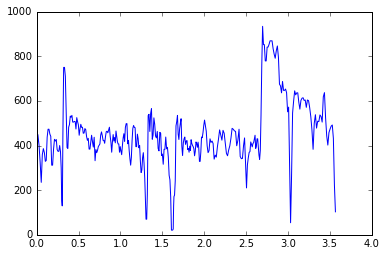

In [24]:
plt.plot((np.array(effortStreams['distance'].data)-effortStreams['distance'].data[0])/1000, effortStreams['watts'].data)

In [39]:
for t in ['heartrate', 'cadence', 'watts']:
    print(t, np.array(effortStreams[t].data).mean())
t = 'velocity_smooth'
print(t, np.array(effortStreams[t].data).mean()*3.6)

heartrate 180.724137931
cadence 98.6120689655
watts 442.706896552
velocity_smooth 37.1265517241


We can see that Michal's average power was 443 watts. This agress with the averages shown in the analysis view. https://www.strava.com/activities/905223228/analysis/25987/26334 <br> Note that the last two codes in this address correspond to start_index and end_index of the segmentEffort

In [40]:
print(segmentEffort.start_index, segmentEffort.end_index)

25987 26334


Put the procedure into a function that takes a rider's strava_id and the precise segment name. This returns a dictionary containing the effort stream.

## A more general example using one of my efforts
This effort_id shows up in the web page address when you highlight your effort https://www.strava.com/activities/909334531/segments/22177936063

In [69]:
effort_id2 = 22177936063
segmentEffort2 = client.get_segment_effort(effort_id2)
effortStreams2 = client.get_effort_streams(effort_id2 ,types)


In [70]:
print(segmentEffort2)
for a in segmentAttributes:
    print(a,getattr(segmentEffort2,a))

<SegmentEffort id=22177936063 name='Lower Hampton Road Sprint' resource_state=3>
name Lower Hampton Road Sprint
segment <Segment id=1008767 name='Lower Hampton Road Sprint' resource_state=2>
activity <Activity id=909334531 name=None resource_state=1>
athlete <Athlete id=351706 firstname=None lastname=None>
kom_rank None
pr_rank None
moving_time 0:04:18
elapsed_time 0:04:18
start_date 2017-03-21 12:34:27+00:00
start_date_local 2017-03-21 12:34:27
distance 3027.20 m
average_watts 321.3
device_watts True
average_heartrate 152.3
max_heartrate 164.0
average_cadence 83.7
start_index 10971
end_index 11229
achievements []


In [71]:
for t in ['heartrate', 'cadence', 'watts']:
    print(t, np.array(effortStreams2[t].data).mean())
t = 'velocity_smooth'
print(t, np.array(effortStreams2[t].data).mean()*3.6)


heartrate 152.254826255
cadence 83.4015444015
watts 321.420849421
velocity_smooth 42.1811583012


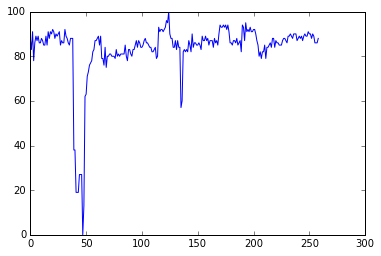

In [72]:
plt.plot(effortStreams2['cadence'].data)

In [68]:
print(effortStreams2['cadence'], 11361-11157)

<Stream type=cadence resolution=high original_size=205> 204
